# Test QDYN with a trivial but rectangular "schedule"

We propagate the same Hamiltonian as in [`2019-08-20_mg_split_ham.ipynb`](2019-08-20_mg_split_ham.ipynb), but we add `schedule` information to the config file that arranges the `ham_matrices` into a $2 \times 3$ schedule. Running this with QDYN's default compilation options should give the same result as the default 1-dimensional schedule, with no significant extra overhead.

In [1]:
from pathlib import Path

In [2]:
import qutip
import numpy as np
import matplotlib.pylab as plt
import scipy.sparse

In [3]:
from src.qdyn.io import read_indexed_matrix
from src.qdyn.model import LevelModel
from src.qdyn.pulse import Pulse
from src.qdyn.io import read_ascii_dump
from src.plots import show_spy, plot_population
from src.ham import rydberg_hamiltonian
from src.blocksplitting import split_AB

In [4]:
%matplotlib inline

In [5]:
V_per_cm = 1.0 / 5.14220624463189208e09

In [6]:
# 1-based indices of the initial and target states
N_INITIAL = 1423
N_TARGET = 2696
# size of Hilbert space
N_HILBERT = N_TARGET

In [7]:
H = rydberg_hamiltonian(
    N_HILBERT,
    'data/ham_drift.dat',
    'data/ham_sig.dat',
    'data/ham_pi.dat',
    F_DC=2.5 * V_per_cm,
    Omega_sigma=Pulse.read('./data/pulse_sig.dat')
)

In [8]:
psi0 = qutip.ket([N_INITIAL-1], dim=H[0].shape[0])
psi_target = qutip.ket([N_TARGET-1], dim=H[0].shape[0])

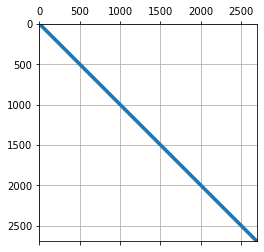

In [9]:
show_spy(H[0].data, show_diagonal=False, grid=True)

In [10]:
def split_list(lst, n):
    splitted = []
    for i in reversed(range(1, n + 1)):
        split_point = len(lst)//i
        splitted.append(lst[:split_point])
        lst = lst[split_point:]
    return splitted

In [11]:
def split_diagonal_hamiltonian(H0, n_blocks):
    diag_data = H0.diag()
    assert (H0 - qutip.qdiags(diag_data, 0)).data.nnz == 0
    res = []
    for i in range(n_blocks):
        res.append(diag_data.copy())
        for j in range(n_blocks):
            if i == j:
                continue
            res[-1][split_list(range(len(diag_data)), n_blocks)[j]] = 0
        res[-1] = qutip.qdiags(res[-1], 0)
    return res        

In [12]:
H0s = split_diagonal_hamiltonian(H[0], 3)

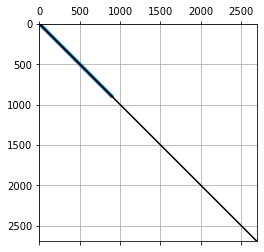

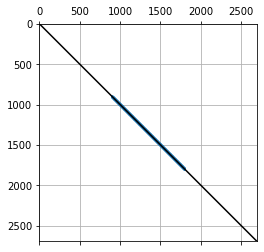

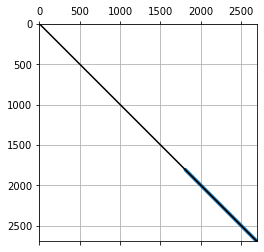

In [13]:
for _H in H0s:
    show_spy(_H, show_diagonal=True, grid=True)

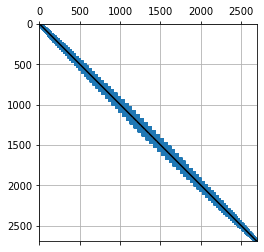

In [14]:
show_spy((H[1][0].data + H[2][0].data), show_diagonal=True, grid=True)

In [15]:
A, B = split_AB(
    H[1][0].data,
    block_info=np.genfromtxt("./data/n_states_red_block.dat", dtype=np.int32),
    n=N_HILBERT,
)

In [16]:
A, B = qutip.Qobj(A), qutip.Qobj(B)

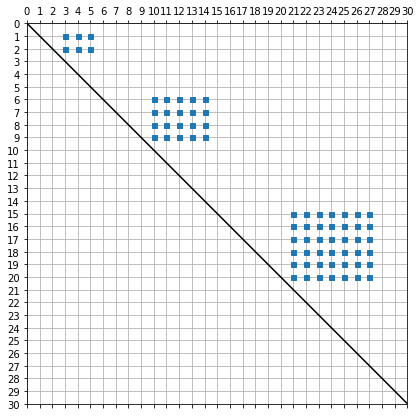

In [17]:
show_spy(
    A,
    figsize=(7, 7),
    show_diagonal=True,
    grid=True,
    xlim=(0, 30),
    ylim=(30, 0),
    label_pixels=True,
    markersize=5,
)

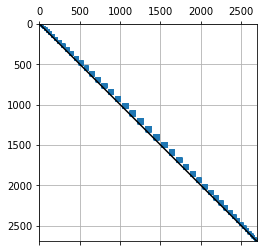

In [18]:
show_spy(B, show_diagonal=True, grid=True)

In [19]:
qdyn_model = LevelModel()

In [20]:
for (i, H0) in enumerate(split_diagonal_hamiltonian(H[0], 2)):
    qdyn_model.add_ham(H0, op_unit='au', op_type='pot', schedule="%d,1,2,3" % (i+1))

In [21]:
qdyn_model.add_ham(A, pulse=H[1][1], op_unit='au', op_type='dip', schedule="1,2,2,3")

In [22]:
qdyn_model.add_ham(B, pulse=H[1][1], op_unit='au', op_type='dip', schedule="2,2,2,3")

In [23]:
qdyn_model.add_ham(A.dag(), pulse=H[1][1], op_unit='au', op_type='dip', conjg_pulse=True, schedule="1,3,2,3")

In [24]:
qdyn_model.add_ham(B.dag(), pulse=H[1][1], op_unit='au', op_type='dip', conjg_pulse=True, schedule="2,3,2,3")

In [25]:
qdyn_model.add_state(psi0, label='initial')

In [26]:
qdyn_model.add_state(psi_target, label='target')

In [27]:
qdyn_model.add_observable(
    qutip.ket2dm(psi0),
    'population.dat',
    exp_unit='iu',
    time_unit='ns',
    col_label='initial',
)
qdyn_model.add_observable(
    qutip.ket2dm(psi_target),
    'population.dat',
    exp_unit='iu',
    time_unit='ns',
    col_label='target',
)

In [28]:
qdyn_model.set_propagation(
    T=H[1][1].T,
    nt=len(H[1][1].states_tgrid),
    time_unit=H[1][1].time_unit,
)

In [29]:
RF = './rf_trivial_schedule_prop'

In [30]:
qdyn_model.write_to_runfolder(RF)

In [31]:
%%bash -s "$RF"
qdyn_prop_traj --version
time qdyn_prop_traj --debug --state-label=initial $1

QDYN 2.0dev revision 2b2fa92f1a71e2a8d932a667b7980c5428c8cce7 (rydbergparallel)
  features: no-check-cheby, no-check-newton, parallel-ham=sequential, use-mkl=sequential, parallel-oct, backtraces, no-debug, no-no-ipo
  compiled with ifort on Sat Aug 24 18:53:23 2019 on host katamon
***** START OF PROGRAM qdyn_prop_traj ******
Sat Aug 24 18:58:07 +0200 2019

*** Read config file ./rf_trivial_schedule_prop/config ***
*** Done reading config file ***
Set option debug to .true.
Set option state_label to initial
args allocated for  1 arguments
Set arg  1 to ./rf_trivial_schedule_prop                                                                                                                                                                                                                                                                                                                                                                                                                                

1

real	3m2.120s
user	3m0.648s
sys	0m1.348s


In [32]:
pop_data = np.genfromtxt((Path(RF) / 'population.dat')).transpose()

In [33]:
pop_data_baseline = np.genfromtxt('./rf_baseline/population.dat').transpose()

/home/goerz/rydberg_parallelization/.venv/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/goerz/rydberg_parallelization/.venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


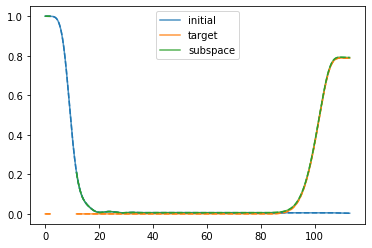

In [34]:
plot_population(pop_data, pop_data_baseline, alpha=0.8)

In [35]:
ham_data = read_ascii_dump(Path(RF) / 'gen.debug')['ham']

In [36]:
ham_data['schedule']

[OrderedDict([('sched_type', 'op_matrix'), ('i', 1)]),
 OrderedDict([('sched_type', 'op_matrix'), ('i', 2)]),
 OrderedDict([('sched_type', 'op_matrix'), ('i', 3)]),
 OrderedDict([('sched_type', 'op_matrix'), ('i', 4)]),
 OrderedDict([('sched_type', 'op_matrix'), ('i', 5)]),
 OrderedDict([('sched_type', 'op_matrix'), ('i', 6)])]